Now, adding more complexity to the model through an Autoregressive, Moving Average model.
<br>

This model has several underlying assumptions:
* Removal of trends or seasonality
* Data must be in stationary form
* Data can be made stationary by differencing techniques 
* The model will be trained to make predictions
    * After predictions are made, seasonal patterns are added to get final predictions 

Our Dickey-Fuller test showed us that this particular time series has no unit root and is indeed stationary

<h3 align="center">Autocorrelation</h3>

Correlation is a metric which is used to summarise the statistical relationship between two variables
* Pearson's correlation coefficient is between -1 (perfect negative) and + 1 (perfect positive), with 0 indicating no correlation at all

#### Correlation in Time Series Data
* Data is sequential in time series, i.e. not independent, so the value of a given variable at time t is likely to be correlated with the same variable in period t-1
* These time steps are referred to as lags, and the correlation between lags is called autocorrelation
* Using Statsmodels api it is able to plot an autocorrelation graph called a correlogram
<br>

* There is also partial autocorrelation, which aims to isolate the correlation of a variable having removed the effect all time lags in between
* Again, Statsmodels api has a function which allows you to plot a partial autocorrelation graph 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import split
from numpy import array

data = pd.read_csv('final_df.csv',infer_datetime_format=True,
                    index_col=['datetime'])
data.index = pd.to_datetime(data.index)
print(data.shape)
data.head(3)

(2007305, 8)


,global_active_power,voltage,year,quarter,month,day,temperature,weekday
datetime,,,,,,,,
2007-01-01 00:00:00,2.580,241.97,2007,1,1,1,13.3,1
2007-01-01 00:01:00,2.552,241.75,2007,1,1,1,13.3,1
2007-01-01 00:02:00,2.550,241.64,2007,1,1,1,13.3,1


## SARIMA MODELLING

Seasonal autoregression integrated moving average model

In [2]:
def train_test_split(data):
#     splitting the data 80/20
    train_size = int(0.8*data.shape[0])
    test_size = int(len(data)) - train_size
    train_y, test_y = data[:train_size].global_active_power, data[-test_size:].global_active_power
    train_X, test_X = data[:train_size][['voltage', 'temperature']], data[-test_size:][['voltage', 'temperature']]
#     train_X, test_X = data[:train_size].drop('global_active_power', axis=1), data[-test_size:].drop('global_active_power', axis=1)
#     train = array(split(train, len(train)/24))
#     test = array(split(test, len(test)/24))
#     returning an array of data in shape (days, hours, variables)
    return train_y, test_y, train_X, test_X

# def make_series(data):
#     #we just need the total power, which is in the first column
#     series = [week[:, 0] for week in data]
#     series = array(series).flatten()
#     return series

# train_series = make_series(train)

In [3]:
# setting a frequency so ARIMA can interpet properly
data.index = pd.DatetimeIndex(data.index.values,
                              freq=data.index.inferred_freq)
train_y, test_y, train_X, test_X = train_test_split(data)

print(train_y.shape, test_y.shape, train_X.shape, test_X.shape)

(1605844,) (401461,) (1605844, 2) (401461, 2)


#### Checking for autocorrelation and partial autocorrelation to make a model

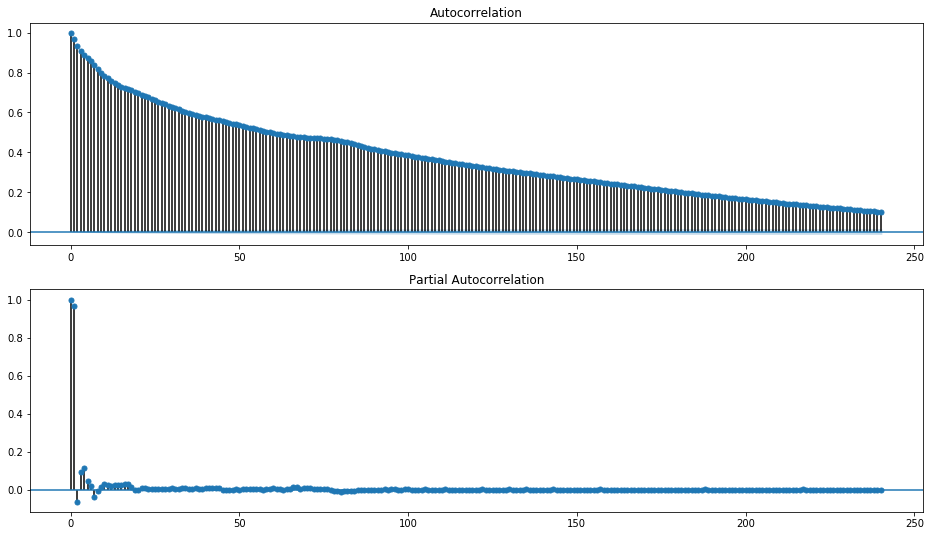

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize = (16, 9))
# acf 
axis = plt.subplot(2, 1, 1)
plot_acf(train_y, ax=axis, lags=240)
# pacf
axis = plt.subplot(2, 1, 2)
plot_pacf(train_y, ax=axis, lags=240)

plt.show();

Lags are quite self explanatory. Strong autocorrelation for previous minutes, 240 lags is about 3 hours

Partial autocorrelation is not significant after a few lags, this is because consumption is quite sequential

In [5]:
import itertools
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p = range(0, 3)
    d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    m_params = seasonal
    # create config instances
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            cfg = [(param), (param_seasonal)]
            models.append(cfg)
    return models

sarima_config_list = sarima_configs(seasonal = [12])
len(sarima_config_list)

144

In [21]:
! sudo pip install statsmodels

In [4]:
train_y.index = pd.DatetimeIndex(train_y.index).to_period('min')
train_X.index = pd.DatetimeIndex(train_X.index).to_period('min')

In [27]:
# import statsmodels.api as sm
# # data.global_active_power.index = pd.DatetimeIndex(data.global_active_power.index.values,
# #                                freq=train_X.index.inferred_freq)
# # train_X.index = pd.DatetimeIndex(train_X.index).to_period('T, min')
# ans = []
# for combs in sarima_config_list[6]:
#     try:
#         mod = sm.tsa.statespace.SARIMAX(train_y,
#                                         order=combs[0],
#                                         seasonal_order=combs[1],
#                                         enforce_stationarity=False,
#                                         enforce_invertibility=False)

#         output = mod.fit()
#         ans.append([combs[0], combs[1], output.aic])
#         print('ARIMA {} x {}12 : AIC Calculated ={}'.format(combs[0], combs[1], output.aic))
#     except:
#         continue

In [14]:
from pmdarima.arima import auto_arima

step_wise=auto_arima(train_y, 
                     exogenous= train_X,
                     start_p=1, start_q=1, 
                     max_p=7, max_q=7, 
                     d=0, max_d=7,
                     m=12, max_P=3,
                     max_Q=3, max_D=2,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True)

In [279]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                27283
Model:               SARIMAX(3, 1, 2)   Log Likelihood             -133688.094
Date:                Sat, 18 Jan 2020   AIC                         267404.188
Time:                        15:48:50   BIC                         267519.184
Sample:                    01-01-2007   HQIC                        267441.253
                         - 02-10-2010                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       0.0304      0.010      3.148      0.002       0.011       0.049
voltage        -0.2136      0.002   -129.663      0.000      -0.217      -0.210
year         -281.9965     12.168    -23.175      0.000    -305.846    -258.147
quarter         6.0778      6.616      0.919      0.358      -6.889      19.045
month         -24.3528      2.209    -11.025      0.000     -28.682     -20.024
day            -0.0703      0.026     -2.722      0.006      -0.121      -0.020
temperature    -0.0091      0.021     -0.434      0.665      -0.050       0.032
weekday        -7.0496      1.042     -6.766      0.000      -9.092      -5.008
ar.L1          -0.3031      0.039     -7.718      0.000      -0.380      -0.226
ar.L2           0.5562      0.025     22.408      0.000       0.508       0.605
ar.L3          -0.0659      0.005    -12.440      0.000      -0.076      -0.055
ma.L1          -0.0262      0.039     -0.670      0.503      -0.103       0.050
ma.L2          -0.9321      0.038    -24.325      0.000      -1.007      -0.857
sigma2       1043.1190      6.977    149.515      0.000    1029.445    1056.793
===================================================================================
Ljung-Box (Q):                     1280.59   Jarque-Bera (JB):              7194.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# step_wise summary is tellling us that we should choose a SARIMAX model of order (3, 1, 2)
# we now need to input our best model into the statsmodel SARIMAX model
import statsmodels.api as sm
# model training
best_model = sm.tsa.statespace.SARIMAX(endog=train_y,
                                       exog=train_X,
                                       order=(1, 1, 1), 
                                       seasonal_order=(1, 1, 1, 12),
                                       enforce_stationarity=False, 
                                       enforce_invertibility=False)

# fitting the model
results = best_model.fit()
print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(18,8))
plt.show();

In [ ]:
pred = results.get_prediction(start=len(train_y), end = len(train_y) + len(test_y) -1 , exog=test_X , dynamic=False)
pred_ci = pred.conf_int(alpha = 0.1)
ax = data.global_active_power['2009':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Global Active Power')
plt.legend()
plt.show()

In [352]:
predictions = results.predict(start=len(train_y), end = len(train_y) + len(test_y) -1 , exog=test_X )
forecasted = results.forecast(steps=len(test_y), exog=test_X)

# creating a dataframe for actual power consumption
actual = pd.DataFrame(data.iloc[len(train_y):, 0])

# creating a dataframe to store actual, predicted as well as dates
predictions = pd.DataFrame(predictions)
predictions['true'] = actual['global_active_power']
predictions.rename(columns={0:'pred'}, inplace=True)
predictions.head(3)
        

,pred,true
2010-02-10 19:00:00,139.225434,101.458
2010-02-10 20:00:00,149.253149,100.614
2010-02-10 21:00:00,162.178854,170.178


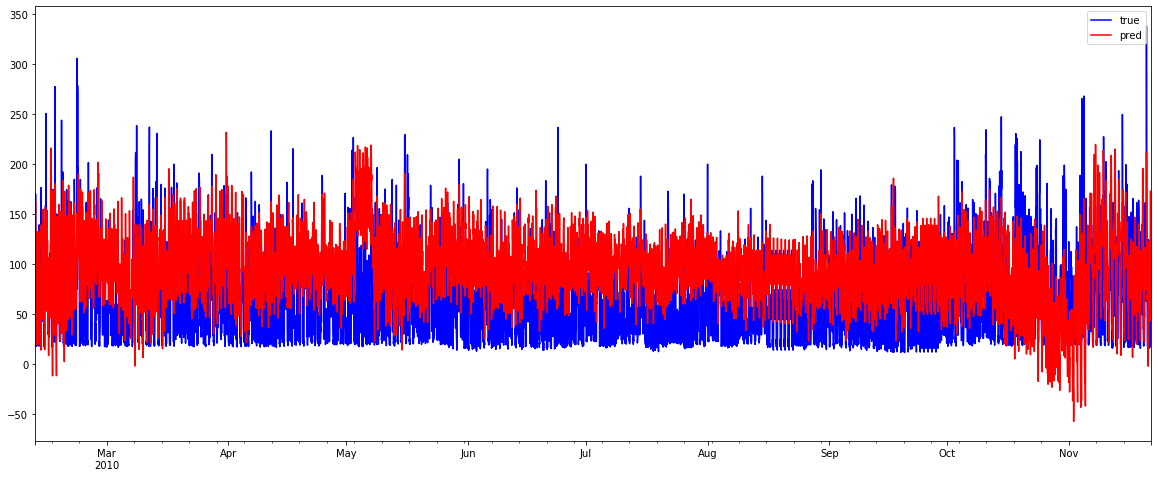

In [354]:
# plotting the actual and predicted data
predictions['true'].plot(figsize=(20,8), legend=True, color='b')
predictions['pred'].plot(legend=True, color='r', figsize=(20,8))
plt.show();
# underestimating a lot dunno why

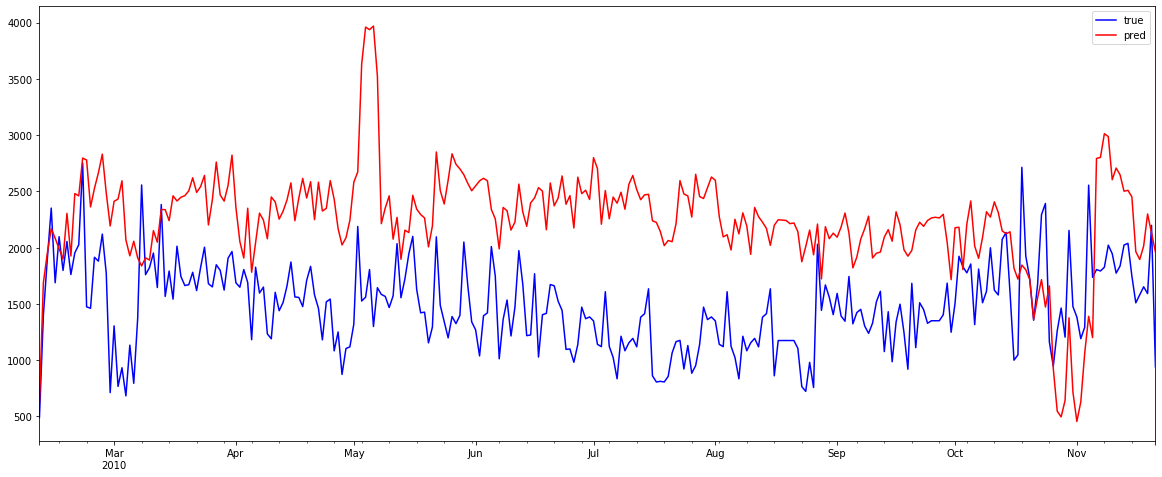

In [355]:
# predictions with daily totals
predictions_days = predictions.resample('D').sum()

predictions_days['true'].plot(figsize=(20,8), legend=True, color='b')
predictions_days['pred'].plot(legend=True, color='r', figsize=(20,8))
plt.show();

In [358]:
# predictions, forecast compared with actual data

forecasted = pd.DataFrame(forecasted)
forecasted.reset_index(drop=True, inplace=True)
forecasted.index = test_X.index
forecasted['true'] = data.iloc[len(train_y):, 0]
forecasted.rename(columns={0:'forecast'}, inplace=True)

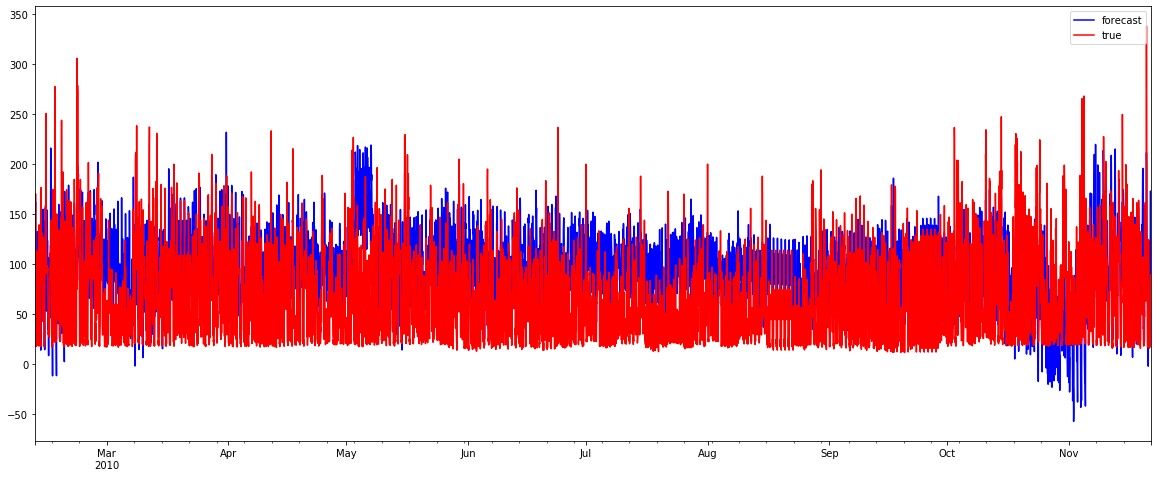

In [359]:
forecasted['forecast'].plot(figsize=(20,8), legend=True, color='b')
predictions['true'].plot(legend=True, color='r', figsize=(20,8))
plt.show();

Evaluating the Model

In [364]:
from statsmodels.tools.eval_measures import rmse

error = rmse(predictions['pred'], predictions['true'])
print(error)

# NB these are not scaled

51.45405522029073


In [ ]:
error